# BTC Predictor

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Stock Predictor Lib


In [2]:
import json as js
import numpy as np
import pandas as pd
from ta import *


class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.iloc[-sampleSize:].copy()
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index]).copy()

    def set_date_as_index_unix(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index], unit='s').copy()

    def split_test_train(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        test_records_count = int(len(self.train) * (1-percent_split))
        self.test = self.train.tail(test_records_count)
        self.train = self.train.head(train_records_count)
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close']]

    def clean_train(self):
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train.fillna(method='ffill', inplace=True)
        self.train.fillna(method='bfill', inplace=True)
        print('Train size: ' + str(len(self.train)))

    """ Trim the beginning to have accurate TA values, trim the end to have accurate target value"""

    def trim_ends(self, begin_count, end_count):
        self.train = self.train.iloc[begin_count:]
        self.train = self.train.iloc[:-end_count]
        print('Trim beginning: ' + str(begin_count) + '. Trim end: ' +
              str(end_count) + '. Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # ////// FEATURE CREATION ///////
    # ///////////////////////////////

    def get_train_size(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        print('Train size: ' + str(train_records_count) +
              ' percent_split: ' + str(percent_split))
        return train_records_count

    def get_validation_indexes(self, train_size, df):
        validation_indexes = list(range(train_size, len(df)))
        print('Validation Index size: ' + str(len(validation_indexes)))
        return validation_indexes

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def get_max_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).max()

    def get_min_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).min()

    def get_moving_average(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).mean()

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)
        self.train['maxc5'] = self.get_max_lookback("Close", 5)
        self.train['maxc15'] = self.get_max_lookback("Close", 15)
        self.train['maxc30'] = self.get_max_lookback("Close", 30)
        self.train['maxc60'] = self.get_max_lookback("Close", 60)
        self.train['maxc90'] = self.get_max_lookback("Close", 90)
        self.train['maxh5'] = self.get_max_lookback("High", 5)
        self.train['maxh15'] = self.get_max_lookback("High", 15)
        self.train['maxh30'] = self.get_max_lookback("High", 30)
        self.train['maxh60'] = self.get_max_lookback("High", 60)
        self.train['maxh90'] = self.get_max_lookback("High", 90)
        self.train['sma5'] = self.get_moving_average("Close", 5)
        self.train['sma15'] = self.get_moving_average("Close", 15)
        self.train['sma30'] = self.get_moving_average("Close", 30)
        self.train['sma60'] = self.get_moving_average("Close", 60)
        self.train['sma90'] = self.get_moving_average("Close", 90)
        self.train['minc5'] = self.get_min_lookback("Close", 5)
        self.train['minc15'] = self.get_min_lookback("Close", 15)
        self.train['minc30'] = self.get_min_lookback("Close", 30)
        self.train['minc60'] = self.get_min_lookback("Close", 60)
        self.train['minc90'] = self.get_min_lookback("Close", 90)
        # rsi = self.train['momentum_rsi']
        # self.train['rsi_category'] = rsi < 30

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        #        ,win_type='boxcar'
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train['action'] = max_lookahead > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_hold(self, target, lookahead, percentIncrease):
        self.train['action'] = 0
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train.loc[max_lookahead > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookahead > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(np.float32)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def set_target_hold_reg(self, target, lookahead, percentIncrease):
        self.train['max_lookahead'] = 0
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train['max_lookahead'] = max_lookahead
        self.train.max_lookahead = self.train.max_lookahead.astype(np.float32)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    def set_target_historical(self, target, lookback, percentIncrease):
        max_in_lookback_timeframe = self.get_max_lookback(target, lookback)
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookback, percentIncrease):
        self.train['action'] = 0
        max_lookback = self.get_max_lookback(target, lookback)
        self.train.loc[max_lookback > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookback > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy_hold(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_sell_actions = df.loc[df.action == 0]
        total_hold_actions = df.loc[df.action == 1]
        total_buy_actions = df.loc[df.action == 2]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        successful_hold_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 2]
        sell_accuracy = len(successful_sell_predictions) / \
            len(total_sell_actions)
        hold_accuracy = len(successful_hold_predictions) / \
            len(total_hold_actions)
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        f1Score = (buy_accuracy + sell_accuracy + hold_accuracy)/3
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'hold_accuracy': round(hold_accuracy, 3),
            'totalSellActions': len(total_sell_actions),
            'totalHoldActions': len(total_hold_actions),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold_reg(self, inputDf, startAmount, fee, percentIncrease):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            threshold = percentIncrease * row.Close
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted >= threshold and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted >= threshold and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted >= row.Close:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted < row.Close and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted < row.Close and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' Close: ' + str(row.Close))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self, path):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{PATH}train')

    def read_from_feather(self, PATH):
        self.train = pd.read_feather(f'{PATH}train')
        # train.drop(self.index,1,inplace=True)

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.reset_index(inplace=True)
        df.plot(
            x='Timestamp',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


## Config


In [3]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *
from IPython.display import HTML
from IPython.core.display import display

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

index='Timestamp'
# index='time_period_start'
lookahead = 15
percentIncrease = 1.002
recordsCount = 120000
test_ratio  = 0.9
train_ratio = 0.9
lr = 1e-4
dropout = 0.01
modelName = 'btcBinaryClassificationModel'
dep = 'action'
PATH='data/stock/'

## Create datasets

In [5]:
table_names = [
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27',
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'btc-bitstamp-2012-01-01_to_2018-01-08'
#         'BTC_COINBASE_2018-07-25_09-06'
#         'ETH_COINBASE_07-21_08-24'
]

In [6]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [7]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [8]:
train= tables[0]

In [9]:
train = train.head(1500000)
p = StockPredictor(train, index)
p.sample_train(recordsCount)

Train size: 110000 Original size: 1500000


## Data Cleaning

In [10]:
p.set_date_as_index_unix()
p.normalize_train('Volume_(BTC)','Open','High','Low','Close')
p.train.head()

,Timestamp,Volume,Open,High,Low,Close
1390000,2017-09-02 00:47:00,4.000356,4944.76,4944.77,4944.71,4944.71
1390001,2017-09-02 00:48:00,24.264185,4944.71,4944.71,4934.98,4935.38
1390002,2017-09-02 00:49:00,10.139276,4935.38,4940.63,4932.43,4938.01
1390003,2017-09-02 00:50:00,4.131629,4938.01,4938.01,4938.01,4938.01
1390004,2017-09-02 00:51:00,4.422197,4938.01,4938.01,4938.00,4938.00


## Join Bitstamp

In [11]:
# bitstamp= tables[1].tail(recordsCount)
# bitstamp[index] = pd.to_datetime(bitstamp[index], unit='s')
# bitstampExtract = pd.DataFrame({
#     'BitstampTimestamp':bitstamp.Timestamp,
#     'BitstampClose':bitstamp.Close,
# })[[ 'BitstampTimestamp','BitstampClose']] 
# bitstampExtract = bitstampExtract.reset_index(drop=True)
# p.train = pd.concat([bitstampExtract, p.train], axis=1)

In [12]:
# valpred = valpred.reset_index(drop=True)
# train = train.set_index(pd.DatetimeIndex(train[index]))
# p.train = p.conflate_time_frame(p.train, '5T')
# len(train)

## Feature Engineering

In [13]:
p.set_target('Close',lookahead, percentIncrease)

Buy count: 39883 Sell count: 70117


In [14]:
# add technical analysis
p.add_ta()
p.clean_train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:607: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:629: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_down = close.rolling(n).apply(lambda x: float(np.argmin(x) + 1) / n * 100)


Train size: 110000


In [15]:
p.add_date_values()
p.trim_ends(100,100)

Trim beginning: 100. Trim end: 100. Train size: 109800


## Split validation and test sets

In [16]:
p.split_test_train(test_ratio)

Train size: 98820 Test size: 10979


In [17]:
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,action,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,sma5,sma15,sma30,sma60,sma90,minc5,minc15,minc30,minc60,minc90,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
1390100,2017-09-02 02:27:00,7.099784,4973.89,4973.89,4973.88,4973.89,0,11.187363,0.000000,-4.538747,0.556178,-0.000000,-0.007957,0.000000,1001.413674,1.020797,4984.452616,4969.062384,4976.7575,0.0,0.0,4978.320667,4979.079667,4977.561667,0.0,0.0,4980.0,4966.69,0.0,0.0,2.977292,4.406973,-1.429681,4976.638195,4973.660902,67.676608,39.651071,59.397304,0,0.912768,1.088025,0.175258,0.013171,20.522990,-46.159915,3.2425,2.929028,3.596031,-0.667002,4960.9050,4952.405,52.0,12.0,40.0,27.406557,39.204122,42.693505,35.141730,18.096515,18.096515,-81.903485,3.876147,0.000000,0.000000,0.590126,4980.00,4980.0,4980.0,4980.0,4980.0,4980.00,4980.0,4980.0,4980.0,4980.0,4976.334,4978.276000,4973.547667,4961.334333,4953.794000,4973.89,4973.89,4966.68,4935.98,4931.76,2017,9,35,2,5,245,False,False,False,False,False,False,1504319220,2,27
1390101,2017-09-02 02:28:00,5.931862,4973.89,4973.89,4973.88,4973.89,0,13.031645,0.000000,-4.538747,0.559484,0.000000,-0.037352,0.000000,1001.413674,0.886024,4983.367492,4970.867508,4977.1175,0.0,0.0,4977.709667,4978.468667,4976.950667,0.0,0.0,4980.0,4971.57,0.0,0.0,2.537523,4.033083,-1.495560,4976.215396,4973.677873,65.293060,24.777887,73.938796,0,0.889437,1.355380,0.465943,0.012114,20.943002,-63.281084,2.8825,2.667885,3.466931,-0.799046,4962.9800,4952.405,48.0,8.0,40.0,27.406557,34.113967,41.665396,31.573458,18.096515,18.096515,-81.903485,2.460912,0.000000,0.000000,0.590126,4980.00,4980.0,4980.0,4980.0,4980.0,4980.00,4980.0,4980.0,4980.0,4980.0,4975.112,4978.202000,4973.766667,4961.832667,4954.262111,4973.89,4973.89,4966.68,4935.98,4931.76,2017,9,35,2,5,245,False,False,False,False,False,False,1504319280,2,28
1390102,2017-09-02 02:29:00,9.381048,4973.89,4973.89,4973.88,4973.88,0,-3.449187,-9.381048,-5.476852,0.490521,-0.022813,-0.064409,-0.000019,1001.413674,0.769221,4983.126551,4971.339449,4977.2330,0.0,0.0,4977.098333,4977.857333,4976.339333,0.0,0.0,4980.0,4973.78,0.0,0.0,2.163259,3.659118,-1.495859,4975.856104,4973.692845,69.920652,0.000000,98.165138,0,0.526868,1.800786,1.273919,0.011032,21.218709,-75.326203,2.7670,2.342928,3.301425,-0.958497,4962.9800,4952.405,44.0,4.0,40.0,27.350683,17.204675,40.719958,25.786511,17.962466,18.051832,-82.037534,1.058324,-0.000201,-0.000201,0.589923,4973.89,4980.0,4980.0,4980.0,4980.0,4980.00,4980.0,4980.0,4980.0,4980.0,4973.888,4977.961333,4973.985333,4962.330667,4954.730111,4973.88,4973.88,4966.68,4935.98,4931.76,2017,9,35,2,5,245,False,False,False,False,False,False,1504319340,2,29
1390103,2017-09-02 02:30:00,12.076617,4973.89,4973.89,4973.88,4973.88,0,-21.457665,0.000000,-2.599776,0.403398,-0.061448,-0.064510,-0.000019,1001.413674,0.667991,4983.119373,4971.356627,4977.2380,0.0,0.0,4976.487333,4977.246333,4975.728333,0.0,0.0,4980.0,4973.88,0.0,1.0,1

In [18]:
p.train.tail(50).T.head(100)

,1488870,1488871,1488872,1488873,1488874,1488875,1488876,1488877,1488878,1488879,1488880,1488881,1488882,1488883,1488884,1488885,1488886,1488887,1488888,1488889,1488890,1488891,1488892,1488893,1488894,1488895,1488896,1488897,1488898,1488899,1488900,1488901,1488902,1488903,1488904,1488905,1488906,1488907,1488908,1488909,1488910,1488911,1488912,1488913,1488914,1488915,1488916,1488917,1488918,1488919
Timestamp,2017-11-09 16:37:00,2017-11-09 16:38:00,2017-11-09 16:39:00,2017-11-09 16:40:00,2017-11-09 16:41:00,2017-11-09 16:42:00,2017-11-09 16:43:00,2017-11-09 16:44:00,2017-11-09 16:45:00,2017-11-09 16:46:00,2017-11-09 16:47:00,2017-11-09 16:48:00,2017-11-09 16:49:00,2017-11-09 16:50:00,2017-11-09 16:51:00,2017-11-09 16:52:00,2017-11-09 16:53:00,2017-11-09 16:54:00,2017-11-09 16:55:00,2017-11-09 16:56:00,2017-11-09 16:57:00,2017-11-09 16:58:00,2017-11-09 16:59:00,2017-11-09 17:00:00,2017-11-09 17:01:00,2017-11-09 17:02:00,2017-11-09 17:03:00,2017-11-09 17:04:00,2017-11-09 17:05:00,2017-11-09 17:06:00,2017-11-09 17:07:00,2017-11-09 17:08:00,2017-11-09 17:09:00,2017-11-09 17:10:00,2017-11-09 17:11:00,2017-11-09 17:12:00,2017-11-09 17:13:00,2017-11-09 17:14:00,2017-11-09 17:15:00,2017-11-09 17:16:00,2017-11-09 17:17:00,2017-11-09 17:18:00,2017-11-09 17:19:00,2017-11-09 17:20:00,2017-11-09 17:21:00,2017-11-09 17:22:00,2017-11-09 17:23:00,2017-11-09 17:24:00,2017-11-09 17:25:00,2017-11-09 17:26:00
Volume,6.40893,2.74302,8.83966,5.14002,19.4386,4.12982,14.4262,6.70662,5.24615,5.43128,3.84635,5.57151,7.54567,2.3965,7.39076,9.02715,11.774,12.0649,7.0207,12.1764,17.0321,15.7952,4.61339,19.0975,17.019,10.47,6.17611,3.95835,2.52936,14.2315,14.8706,12.2504,19.5347,18.2368,8.82761,7.60432,8.44611,5.95141,3.9961,2.06136,5.2767,8.82511,6.45925,9.56632,11.777,8.58629,3.3482,9.7312,7.21017,9.17716
Open,7184,7187.43,7189,7191.02,7191.02,7191.02,7191.02,7187.43,7187.12,7187.11,7187.11,7187.11,7187.1,7187.11,7187.1,7187.11,7185,7182.03,7180.01,7178.59,7171.2,7171.12,7171.12,7171.12,7178.26,7176.81,7178.29,7179,7180,7180,7180,7180,7176.01,7170.01,7167.91,7182,7183,7179.01,7175,7175,7180,7182.99,7183,7183,7188,7189.42,7189.31,7189.31,7189.31,7189.01
High,7187.81,7189,7193,7191.02,7191.02,7191.02,7191.02,7187.43,7187.12,7187.11,7187.11,7187.11,7187.11,7187.11,7187.11,7187.11,7185.01,7182.03,7180.01,7178.76,7171.2,7171.12,7171.12,7178.3,7178.26,7178.3,7179,7180,7180,7180,7180.01,7180,7176.01,7170.01,7182,7183,7183,7179.01,7175,7180,7182.99,7183,7183,7188,7190,7189.42,7189.31,7189.31,7189.31,7189.01
Low,7184,7187.42,7189,7191.01,7191.01,7191.01,7187.43,7187.11,7187.11,7187.1,7187.1,7187.1,7187.1,7187.1,7187.1,7185.01,7180,7180,7177.63,7170.99,7170.01,7171,7171.11,7171.12,7175.01,7176.8,7178.29,7178.99,7179.99,7179.99,7179.99,7176,7170,7167.9,7167.91,7182,7179,7175,7174.35,7175,7179.99,7182.99,7182.99,7183,7188,7189.3,7189.3,7189.3,7189.01,7185.91
Close,7187.43,7189,7191.02,7191.02,7191.02,7191.02,7187.43,7187.12,7187.11,7187.11,7187.11,7187.11,7187.11,7187.11,7187.11,7185.01,7182.18,7180,7179.11,7171.17,7171.12,7171.12,7171.12,7178.26,7176.8,7178.3,7178.99,7180,7179.99,7180,7179.99,7176.01,7170,7167.91,7182,7183,7179,7175,7175,7180,7182.99,7182.99,7183,7188,7190,7189.31,7189.31,7189.3,7189.01,7185.91
action,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
volume_adi,2.3314,7.87353,2.83141,5.22842,24.5786,23.5684,-10.2964,-20.7137,-11.5336,0.185138,9.27763,9.41786,13.1172,9.94217,9.78726,-1.63639,-10.5547,-13.5925,-10.354,-9.90134,3.12984,30.5374,20.4086,23.4981,20.6128,12.198,16.4721,9.96048,1.42899,11.7021,-0.639099,-27.0598,-31.7239,-37.5986,-9.23631,16.4319,-0.841792,-14.3975,-1.9553,6.05747,7.33806,-3.54841,-2.36587,16.0256,21.3433,4.62178,-3.80705,-6.38301,-16.9414,-16.3873
volume_obv,6.40893,2.74302,8.83966,0,0,0,-14.4262,-6.70662,-5.24615,0,0,0,0,0,0,-9.02715,-11.774,-12.0649,-7.0207,-12.1764,-17.0321,0,0,19.0975,-17.019,10.47,6.17611,3.95835,-2.52936,14.2315,-14.8706,-12.2504,-19.5347,-18.2368,8.82

## Create features

Identify categorical vs continuous variables

In [19]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

# 'BitstampClose',

contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b'
,'trend_aroon_up','trend_aroon_down','trend_aroon_ind','momentum_rsi','momentum_mfi','momentum_tsi',
'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao','others_dr','others_dlr','others_cr'
,'maxc5','maxc15','maxc30','maxc60','maxc90','maxh5','maxh15','maxh30','maxh60','maxh90'
,'sma5','sma15','sma30','sma60','sma90','minc5','minc15','minc30','minc60','minc90']

p.test = p.test.set_index('Timestamp')
p.train = p.train.set_index('Timestamp')

len(contin_vars),len(contin_vars) -5

(84, 79)

In [20]:
p.train = p.train[cat_vars+contin_vars+[dep]].copy()
p.test = p.test[cat_vars+contin_vars+[dep]].copy()

In [21]:
for v in cat_vars: 
    p.train[v] = p.train[v].astype('category').cat.as_ordered()
    p.test[v] = p.test[v].astype('category').cat.as_ordered()

In [22]:
apply_cats(p.test, p.train)

In [23]:
for v in contin_vars:
    p.train[v] = p.train[v].astype('float32')
    p.test[v] = p.test[v].astype('float32')

In [24]:
df, y, nas, mapper = proc_df(p.train, dep, do_scale=True)

In [25]:
df_test, _, nas, mapper = proc_df(p.test, dep, do_scale=True, mapper=mapper, na_dict=nas)
p.train.head(30).T.head(70)

Timestamp,2017-09-02 02:27:00,2017-09-02 02:28:00,2017-09-02 02:29:00,2017-09-02 02:30:00,2017-09-02 02:31:00,2017-09-02 02:32:00,2017-09-02 02:33:00,2017-09-02 02:34:00,2017-09-02 02:35:00,2017-09-02 02:36:00,2017-09-02 02:37:00,2017-09-02 02:38:00,2017-09-02 02:39:00,2017-09-02 02:40:00,2017-09-02 02:41:00,2017-09-02 02:42:00,2017-09-02 02:43:00,2017-09-02 02:44:00,2017-09-02 02:45:00,2017-09-02 02:46:00,2017-09-02 02:47:00,2017-09-02 02:48:00,2017-09-02 02:49:00,2017-09-02 02:50:00,2017-09-02 02:51:00,2017-09-02 02:52:00,2017-09-02 02:53:00,2017-09-02 02:54:00,2017-09-02 02:55:00,2017-09-02 02:56:00
TimestampYear,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
TimestampMonth,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
TimestampWeek,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
TimestampDay,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
hour,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
minute,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
TimestampDayofweek,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
TimestampDayofyear,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245
TimestampIs_month_end,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TimestampIs_month_start,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [26]:
nas={}

In [27]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,sma5,sma15,sma30,sma60,sma90,minc5,minc15,minc30,minc60,minc90
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-02 02:27:00,1,1,1,2,3,28,6,1,1,1,1,1,1,1,-0.043052,-0.043043,-0.044514,-0.041381,-0.155199,-1.732128,0.332865,-0.004004,-0.58193,0.996440,0.023319,-0.011580,0.00904,-1.092937,-0.612110,-0.049023,-0.031520,-0.040302,-0.266042,-0.270765,-0.038934,-0.041398,-0.036468,-0.110778,-0.085551,-0.049162,-0.036660,-0.565882,-0.429611,0.381388,0.610249,-0.642314,-0.040485,-0.043012,0.376722,-0.001249,0.755640,-0.958462,-0.092809,0.079196,-0.295807,0.611185,-0.857189,-0.543471,0.366846,0.558131,0.704842,-0.422166,-0.053283,-0.059842,0.143594,-0.904850,0.594502,-0.92386,-0.436819,1.416599,-0.840739,-0.994196,-1.045889,-0.994196,0.190056,-0.003708,-0.003109,-0.043043,-0.041413,-0.047051,-0.052739,-0.060956,-0.067315,-0.042692,-0.048234,-0.05389,-0.062084,-0.06844,-0.040822,-0.038993,-0.043075,-0.053704,-0.060161,-0.039006,-0.032649,-0.032502,-0.050336,-0.046547
2017-09-02 02:28:00,1,1,1,2,3,29,6,1,1,1,1,1,1,1,-0.043052,-0.043043,-0.044514,-0.041381,-0.224496,-1.732128,0.404325,-0.004004,-0.58193,1.005383,0.023319,-0.012033,0.00904,-1.092937,-0.643716,-0.049989,-0.029902,-0.039980,-0.266042,-0.270765,-0.039480,-0.041943,-0.037014,-0.110778,-0.085551,-0.049162,-0.032291,-0.565882,-0.429611,0.321927,0.556567,-0.671915,-0.040863,-0.042997,0.276259,-0.479754,1.266031,-0.958462,-0.103795,0.258768,-0.179326,0.560685,-0.754231,-0.726521,0.326534,0.506593,0.678806,-0.505757,-0.051428,-0.059842,0.032070,-1.018777,0.594502,-0.92386,-0.616442,1.379699,-0.976515,-0.994196,-1.045889,-0.994196,0.114342,-0.003708,-0.003109,-0.043043,-0.041413,-0.047051,-0.052739,-0.060956,-0.067315,-0.042692,-0.048234,-0.05389,-0.062084,-0.06844,-0.041914,-0.039059,-0.042879,-0.053259,-0.059743,-0.039006,-0.032649,-0.032502,-0.050336,-0.046547


In [28]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,sma5,sma15,sma30,sma60,sma90,minc5,minc15,minc30,minc60,minc90
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-09 17:28:00,1,3,11,9,18,29,4,69,1,1,1,1,1,1,1.932318,1.932275,1.93041,1.934395,0.051184,1.731983,-0.337100,-0.557678,-0.230046,-1.166050,0.023293,-0.000374,0.008946,2.404477,-0.525441,1.919930,1.939779,1.930043,-0.266042,-0.270765,1.934052,1.930982,1.937096,-0.110778,-0.085551,1.920354,1.934293,-0.565882,-0.429611,0.274771,0.250889,0.127957,1.932576,1.931130,-1.179303,1.159153,-0.611573,1.043339,0.193569,-0.233537,-0.005981,0.158764,-0.137970,0.340229,0.038807,0.165823,0.065414,0.326578,1.929098,1.925486,0.701215,-0.449141,0.658913,0.006269,-0.278653,0.089500,-0.984783,0.454142,0.478945,0.454142,0.387270,-0.004871,-0.004271,1.932275,1.930114,1.923182,1.91555,1.905338,1.896669,1.928577,1.92184,1.914308,1.905964,1.897363,1.93358,1.931750,1.928969,1.931312,1.928815,1.93794,1.937185,1.940213,1.954039,1.951702
2017-11-09 17:29:00,1,3,11,9,18,30,4,69,1,1,1,1,1,1,1.932318,1.927060,1.93041,1.929179,-0.155683,1.732058,-0.785261,-0.375190,-0.400911,-1.004068,-0.005406,-0.002609,-0.027779,2.401193,-0.385997,1.919169,1.941445,1.930493,-0.266042,-0.270765,1.933964,1.931415,1.936486,-0.110778,-0.085551,1.920354,1.934293,-0.565882,-0.429611,0.191169,0.241308,-0.119875,1.931790,1.930897,-1.218623,0.652653,-0.032405,1.043339,0.044852,-0.288499,-0.099748,0.158317,-0.079947,-0.172143,-0.017518,0.176506,0.091105,0.280202,1.928647,1.925486,0.589691,-0.563068,0.658913,-0.759344,-0.403495,0.066205,-1.231134,-0.587639,0.113041,-0.587639,0.313093,-0.682475,-0.682039,1.927060,1.929855,1.923182,1.91555,1.905338,1.896669,1.928577,1.92184,1.914308,1.905964,1.897363,1.93193,1.932052,1.929235,1.931286,1.928873,1.93272,1.937185,1.940213,1.954039,1.951702


Rake the last x% of rows as our validation set.

In [29]:
train_size = p.get_train_size(train_ratio)
val_idx = p.get_validation_indexes(train_size, df)

Train size: 88938 percent_split: 0.9
Validation Index size: 9882


## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set True because there there are three labels for target BUY,HOLD,SELL

In [30]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [31]:
cat_sz = [(c, len(p.train[c].cat.categories)+1) for c in cat_vars]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [32]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [33]:
cont_size = len(df.columns)-len(cat_vars)

In [34]:
# m = md.get_learner(emb_szs, cont_size,dropout, 2, [100,50], [0.03,0.06],None,True)
activations=[500,100]
# todo: play with drop out layers
dropout_later_layers= [0.01,0.1] 
m = md.get_learner(emb_szs, cont_size,dropout, 2, activations,dropout_later_layers ,None,True)


 73%|███████▎  | 1018/1390 [00:08<00:02, 168.03it/s, loss=1.54]


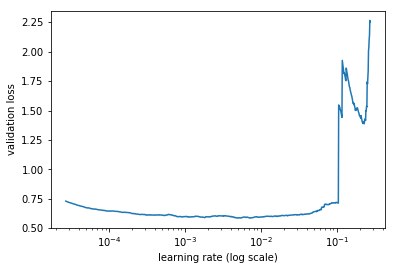

In [35]:
m.lr_find()
m.sched.plot(100)

In [36]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                  
    0      0.578468   0.657684  
    1      0.577416   0.69587                                   
    2      0.56152    0.666805                                  



[array([0.6668])]

In [37]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      0.565994   0.671171  
    1      0.552134   0.684183                                  
    2      0.552429   0.677788                                  
    3      0.54356    0.682735                                  
    4      0.541491   0.696933                                  



[array([0.69693])]

In [38]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                  
    0      0.542279   0.743707  
    1      0.536843   0.716947                                  
    2      0.535088   0.72696                                   
    3      0.535697   0.728728                                  
    4      0.528961   0.732325                                  
    5      0.530587   0.768046                                  
    6      0.518518   0.811867                                  
    7      0.513564   0.893594                                  
    8      0.503449   0.783408                                  
    9      0.493374   0.856138                                  
    10     0.501176   0.835619                                  
    11     0.502091   0.840847                                  
    12     0.503516   0.828552                                  
    13     0.497963   0.8471                                    
    14     0.48754    1.019878                           

[array([1.22523])]

In [39]:
m.save(modelName)

In [40]:
m.load(modelName)

## Validation

In [41]:
(x,y1)=m.predict_with_targs()

In [42]:
val = p.train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({
    'Close':val.Close,
    'index':val.index,
    'action':val.action,
    'predicted':np.argmax(x,axis=1)
})[['Close','index', 'action','predicted']]
valpred.tail(100)

,Close,index,action,predicted
Timestamp,,,,
2017-11-09 15:47:00,7146.009766,2017-11-09 15:47:00,1,1
2017-11-09 15:48:00,7145.910156,2017-11-09 15:48:00,1,1
2017-11-09 15:49:00,7161.680176,2017-11-09 15:49:00,1,1
2017-11-09 15:50:00,7153.830078,2017-11-09 15:50:00,1,1
2017-11-09 15:51:00,7172.410156,2017-11-09 15:51:00,0,0
2017-11-09 15:52:00,7168.899902,2017-11-09 15:52:00,0,0
2017-11-09 15:53:00,7157.000000,2017-11-09 15:53:00,1,0
2017-11-09 15:54:00,7161.020020,2017-11-09 15:54:00,1,1
2017-11-09 15:55:00,7160.299805,2017-11-09 15:55:00,1,0


Calculate the percent accuracy on the validation set

In [43]:
p.calculate_accuracy(valpred)

{'F1Score': 0.538,
 'totalAccuracy': 0.609,
 'buyAccuracy': 0.114,
 'sellAccuracy': 0.962,
 'totalBuyActions': 4106,
 'successfulBuyPredictions': 467}

In [44]:
p.calculate_net_profit(valpred, 15000, 0)
p.result

{'startClose': 7080.0,
 'endClose': 7185.91,
 'startAmount': 15000,
 'endAmount': 16044.678744447481,
 'buyAndHoldPercentIncrease': 1.496,
 'percentIncrease': 6.965,
 'percentDifference': 5.469,
 'totalTrades': 386}

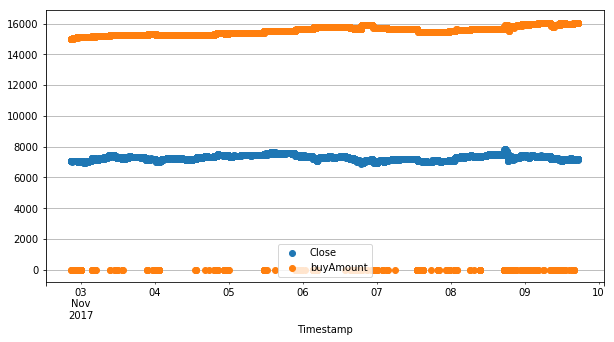

In [45]:
p.plot_profit(p.net_profit_df)

In [46]:
p.net_profit_df

,Timestamp,Close,index,action,predicted,buyAmount,sellAmount
0,2017-11-02 20:45:00,7080.000000,2017-11-02 20:45:00,0,0,15000.000000,0.000000
1,2017-11-02 20:46:00,7085.000000,2017-11-02 20:46:00,0,0,15000.000000,0.000000
2,2017-11-02 20:47:00,7082.009766,2017-11-02 20:47:00,0,0,15000.000000,0.000000
3,2017-11-02 20:48:00,7068.029785,2017-11-02 20:48:00,0,0,15000.000000,0.000000
4,2017-11-02 20:49:00,7068.029785,2017-11-02 20:49:00,0,0,15000.000000,0.000000
5,2017-11-02 20:50:00,7068.060059,2017-11-02 20:50:00,0,1,0.000000,2.122223
6,2017-11-02 20:51:00,7068.020020,2017-11-02 20:51:00,0,0,14999.915028,0.000000
7,2017-11-02 20:52:00,7068.020020,2017-11-02 20:52:00,0,0,14999.915028,0.000000
8,2017-11-02 20:53:00,7051.009766,2017-11-02 20:53:00,0,1,0.000000,2.127343
9,2017-11-02 20:54:00,7040.299805,2017-11-02 20:54:00,1,1,0.000000,2.127343


## Test

In [47]:
np.argmax(m.predict(True), axis =1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [48]:
testPred = pd.DataFrame({
    'index':p.test.index,
    'Close':p.test.Close,
    'action':p.test.action, 
    'predicted':np.argmax(m.predict(True), axis =1)
})[['index','Close','action', 'predicted']]
testPred.head(10)

,index,Close,action,predicted
Timestamp,,,,
2017-11-09 17:28:00,2017-11-09 17:28:00,7185.899902,0,0
2017-11-09 17:29:00,2017-11-09 17:29:00,7180.060059,0,0
2017-11-09 17:30:00,2017-11-09 17:30:00,7180.009766,0,0
2017-11-09 17:31:00,2017-11-09 17:31:00,7180.009766,0,0
2017-11-09 17:32:00,2017-11-09 17:32:00,7180.009766,0,0
2017-11-09 17:33:00,2017-11-09 17:33:00,7184.000000,0,0
2017-11-09 17:34:00,2017-11-09 17:34:00,7185.029785,0,0
2017-11-09 17:35:00,2017-11-09 17:35:00,7183.910156,0,0
2017-11-09 17:36:00,2017-11-09 17:36:00,7183.899902,0,0


In [49]:
p.calculate_accuracy(testPred)

{'F1Score': 0.597,
 'totalAccuracy': 0.597,
 'buyAccuracy': 0.538,
 'sellAccuracy': 0.655,
 'totalBuyActions': 5437,
 'successfulBuyPredictions': 2926}

In [50]:
p.calculate_net_profit(testPred, 15000, 0)
p.result

{'startClose': 7185.9,
 'endClose': 7710.04,
 'startAmount': 15000,
 'endAmount': 21538.621336754502,
 'buyAndHoldPercentIncrease': 7.294,
 'percentIncrease': 43.591,
 'percentDifference': 36.297,
 'totalTrades': 1242}

In [51]:
p.net_profit_df

,index,Close,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2017-11-09 17:28:00,2017-11-09 17:28:00,7185.899902,0,0,15000.000000,0.000000
2017-11-09 17:29:00,2017-11-09 17:29:00,7180.060059,0,0,15000.000000,0.000000
2017-11-09 17:30:00,2017-11-09 17:30:00,7180.009766,0,0,15000.000000,0.000000
2017-11-09 17:31:00,2017-11-09 17:31:00,7180.009766,0,0,15000.000000,0.000000
2017-11-09 17:32:00,2017-11-09 17:32:00,7180.009766,0,0,15000.000000,0.000000
2017-11-09 17:33:00,2017-11-09 17:33:00,7184.000000,0,0,15000.000000,0.000000
2017-11-09 17:34:00,2017-11-09 17:34:00,7185.029785,0,0,15000.000000,0.000000
2017-11-09 17:35:00,2017-11-09 17:35:00,7183.910156,0,0,15000.000000,0.000000
2017-11-09 17:36:00,2017-11-09 17:36:00,7183.899902,0,0,15000.000000,0.000000


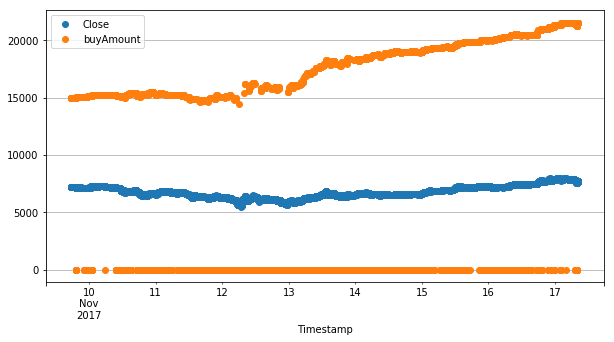

In [52]:
p.plot_profit(p.net_profit_df)